In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pymysql
from sqlalchemy import create_engine
import getpass


from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display="diagram")

In [3]:
password = getpass.getpass()

········


## Project definition

### _In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it_

#### Instructions

Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.
<br>
Read the data into a Pandas dataframe.
<br>
Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.
<br>
Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.
<br>
Create a logistic regression model to predict this variable from the cleaned data.
Evaluate the results.

### Project Setup

- create query to get relevant data from sakila DB
- add to dataframe for further processing

In [45]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

q = '''
SELECT f.*, c.name AS category_name, 
       q.times_rented_aug_2005, q2.times_rented_july_2005,
       q3.times_rented_june_2005, q4.times_rented_may_2005
  FROM film as f
  JOIN film_category AS fc
    ON fc.film_id = f.film_id
  JOIN category as c
    ON c.category_id = fc.category_id
  LEFT JOIN (SELECT f.film_id, COUNT(*) times_rented_aug_2005
		  FROM rental as r
		  JOIN inventory as i
			ON i.inventory_id = r.inventory_id
		  JOIN film as f
			ON f.film_id = i.film_id
		 WHERE SUBSTRING(r.rental_date, 1, 7) = "2005-08"
		 GROUP BY f.film_id) as q
	ON q.film_id = f.film_id
 LEFT JOIN (SELECT f.film_id, COUNT(*) times_rented_july_2005
		  FROM rental as r
		  JOIN inventory as i
			ON i.inventory_id = r.inventory_id
		  JOIN film as f
			ON f.film_id = i.film_id
		 WHERE SUBSTRING(r.rental_date, 1, 7) = "2005-07"
		 GROUP BY f.film_id) as q2
	ON q2.film_id = f.film_id
  LEFT JOIN (SELECT f.film_id, COUNT(*) times_rented_june_2005
		  FROM rental as r
		  JOIN inventory as i
			ON i.inventory_id = r.inventory_id
		  JOIN film as f
			ON f.film_id = i.film_id
		 WHERE SUBSTRING(r.rental_date, 1, 7) = "2005-06"
		 GROUP BY f.film_id) as q3
	ON q3.film_id = f.film_id
  LEFT JOIN (SELECT f.film_id, COUNT(*) times_rented_may_2005
		  FROM rental as r
		  JOIN inventory as i
			ON i.inventory_id = r.inventory_id
		  JOIN film as f
			ON f.film_id = i.film_id
		 WHERE SUBSTRING(r.rental_date, 1, 7) = "2005-05"
		 GROUP BY f.film_id) as q4
	ON q4.film_id = f.film_id;
'''

df = pd.read_sql_query(q, engine)

In [46]:
df.head(1)

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update,category_name,times_rented_aug_2005,times_rented_july_2005,times_rented_june_2005,times_rented_may_2005
0,19,AMADEUS HOLY,A Emotional Display of a Pioneer And a Technic...,2006,1,None,6,0.99,113,20.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,Action,7.0,8.0,4.0,1.0


## Data Cleaning

In [47]:
df.isna().sum()

film_id                      0
title                        0
description                  0
release_year                 0
language_id                  0
original_language_id      1000
rental_duration              0
rental_rate                  0
length                       0
replacement_cost             0
rating                       0
special_features             0
last_update                  0
category_name                0
times_rented_aug_2005       42
times_rented_july_2005      42
times_rented_june_2005     100
times_rented_may_2005      314
dtype: int64

- Drop the original_language_id column
- replace all the nan values in columns times_rented_x with 0 since this will indicate that the respective movie was not rented during this month

In [48]:
df.drop('original_language_id', axis=1, inplace=True)

In [49]:
df['times_rented_aug_2005'].fillna(0, inplace=True)
df['times_rented_july_2005'].fillna(0, inplace=True)
df['times_rented_june_2005'].fillna(0, inplace=True)
df['times_rented_may_2005'].fillna(0, inplace=True)

In [50]:
df.isna().sum()

film_id                   0
title                     0
description               0
release_year              0
language_id               0
rental_duration           0
rental_rate               0
length                    0
replacement_cost          0
rating                    0
special_features          0
last_update               0
category_name             0
times_rented_aug_2005     0
times_rented_july_2005    0
times_rented_june_2005    0
times_rented_may_2005     0
dtype: int64

In [51]:
print(df.select_dtypes('object').apply(lambda col: col.unique()))

title               [AMADEUS HOLY, AMERICAN CIRCUS, ANTITRUST TOMA...
description         [A Emotional Display of a Pioneer And a Techni...
rating                                       [PG, R, NC-17, G, PG-13]
special_features    [Commentaries,Deleted Scenes,Behind the Scenes...
category_name       [Action, Animation, Children, Classics, Comedy...
dtype: object


In [52]:
print(df.select_dtypes('number').apply(lambda col: col.unique()))

film_id                   [19, 21, 29, 38, 56, 67, 97, 105, 111, 115, 12...
release_year                                                         [2006]
language_id                                                             [1]
rental_duration                                             [6, 3, 5, 7, 4]
rental_rate                                              [0.99, 4.99, 2.99]
length                    [113, 129, 168, 68, 77, 56, 125, 52, 167, 179,...
replacement_cost          [20.99, 17.99, 11.99, 25.99, 15.99, 24.99, 21....
times_rented_aug_2005     [7.0, 8.0, 2.0, 0.0, 6.0, 5.0, 11.0, 3.0, 9.0,...
times_rented_july_2005    [8.0, 4.0, 0.0, 11.0, 6.0, 7.0, 5.0, 9.0, 10.0...
times_rented_june_2005             [4.0, 3.0, 2.0, 0.0, 1.0, 5.0, 6.0, 7.0]
times_rented_may_2005                        [1.0, 2.0, 0.0, 3.0, 4.0, 5.0]
dtype: object


- drop release_year and language_id since they have only one value for all samples
- drop last_update column since no usefull info here
- set film_id as index

In [53]:
df.drop(['language_id', 'release_year', 'last_update'], axis=1, inplace=True)

In [54]:
df.select_dtypes('number').columns

Index(['film_id', 'rental_duration', 'rental_rate', 'length',
       'replacement_cost', 'times_rented_aug_2005', 'times_rented_july_2005',
       'times_rented_june_2005', 'times_rented_may_2005'],
      dtype='object')

In [55]:
df.set_index('film_id', inplace=True)
df.head(1)

,title,description,rental_duration,rental_rate,length,replacement_cost,rating,special_features,category_name,times_rented_aug_2005,times_rented_july_2005,times_rented_june_2005,times_rented_may_2005
film_id,,,,,,,,,,,,,
19,AMADEUS HOLY,A Emotional Display of a Pioneer And a Technic...,6,0.99,113,20.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",Action,7.0,8.0,4.0,1.0


## Prepare Target

In [56]:
# create one column which indicates if a movie was rented or not on aug 2005 
# -> this is the target that we want to predict
df['rented'] = [ np.minimum(1.0, val) for val in df['times_rented_aug_2005']]

aug_rented_backup = df['times_rented_aug_2005']

#### Check Target 

In [57]:
df['rented'].value_counts() / df.shape[0]

1.0    0.958
0.0    0.042
Name: rented, dtype: float64

- imbalance between positive and negative class

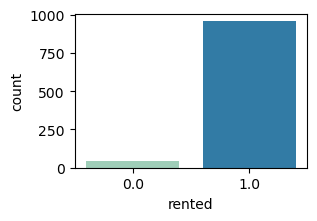

In [58]:
plt.figure(figsize=(3,2))
sns.countplot(x=df['rented'], palette='YlGnBu')
plt.show()

In [59]:
df.drop('times_rented_aug_2005', axis=1, inplace=True) # drop the column from which the target was extracted

# EDA

### Exploring numerical features

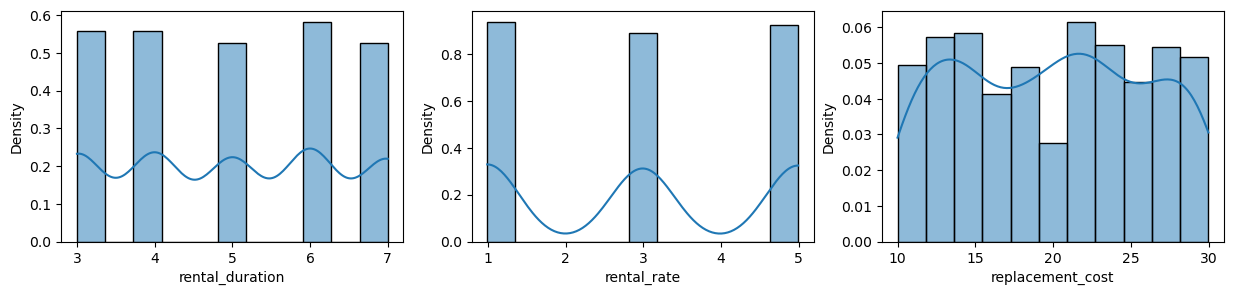

In [60]:
# check discrete features
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
for i, col in enumerate(['rental_duration', 'rental_rate', 'replacement_cost']):
    sns.histplot(data=df[col], kde=True, stat='density', ax=ax[i])
plt.show()

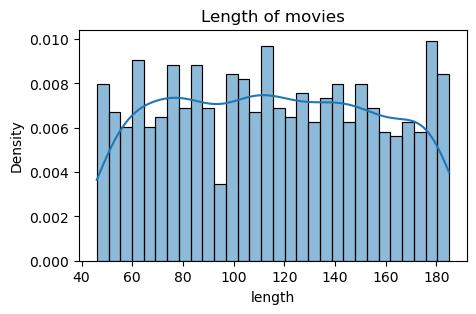

In [61]:
# check the distribution of length of movies
plt.figure(figsize=(5,3))
plt.title('Length of movies')
sns.histplot(data=df['length'], kde=True, stat='density', bins=30)
plt.show()

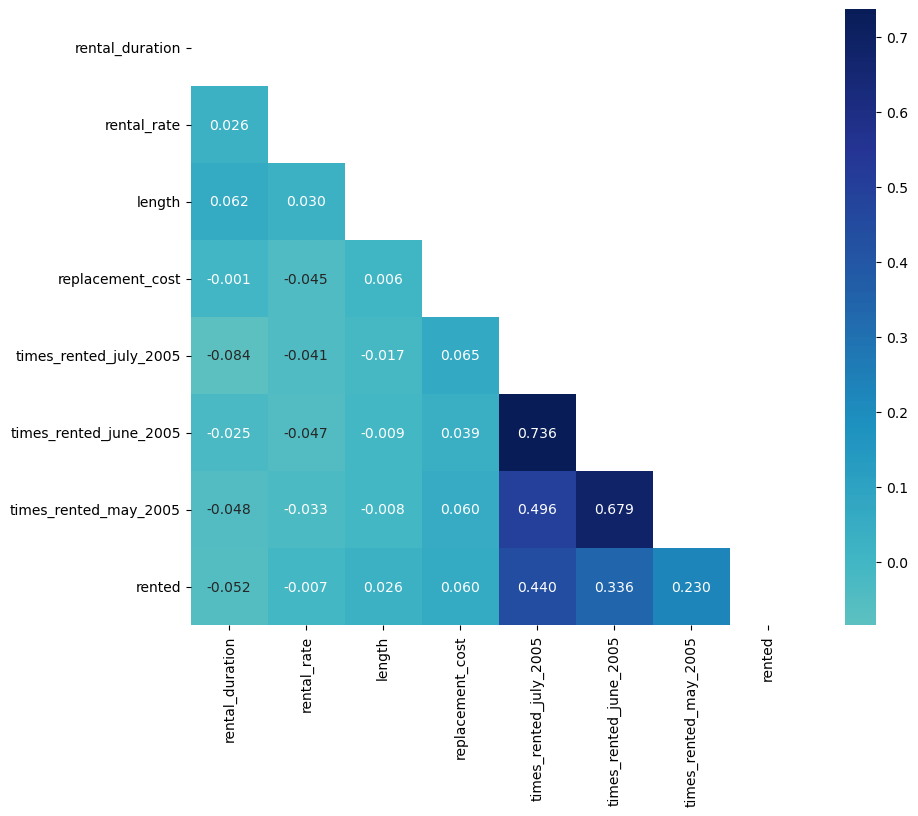

In [62]:
# correlation matrix for numerical features
num_corr = df.select_dtypes('number').corr()
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(num_corr, center=0, fmt=".3f", square=True, annot=True, mask=mask, cmap="YlGnBu")
plt.show()

 - correlation only between the rentals per month meaningful so far

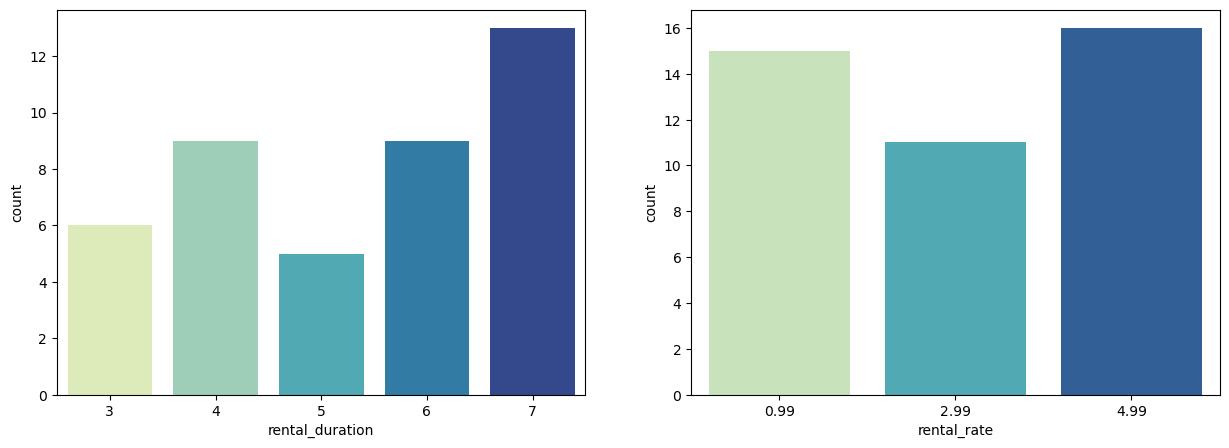

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i, col in enumerate(['rental_duration', 'rental_rate']):
    sns.countplot(x=df[df['rented'] == 0][col], ax=ax[i], palette='YlGnBu')
plt.show()

- no pattern recognizable yet

#### Deeper Look at Fim Length

In [64]:
def categorize_length(v):
    if v < 60:
        return 'short'
    elif v < 120:
        return 'medium'
    elif v < 160:
        return 'long'
    elif v > 161:
        return 'very long'


df['length_category'] = [categorize_length(val) for val in df['length']]

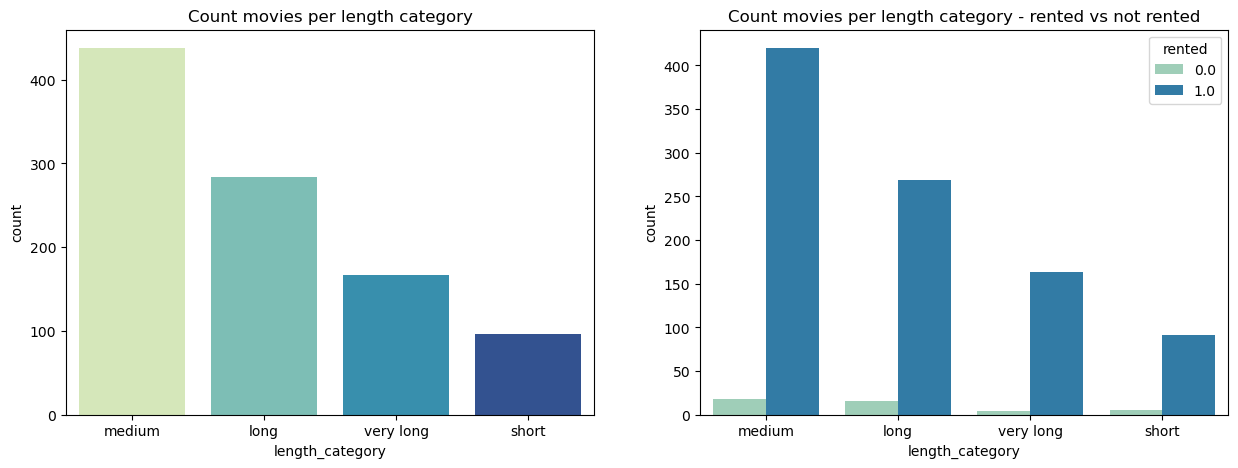

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x=df['length_category'], palette='YlGnBu', ax=ax[0])
ax[0].set_title('Count movies per length category')
sns.countplot(x=df['length_category'], hue=df['rented'], palette='YlGnBu', ax=ax[1])
ax[1].set_title('Count movies per length category - rented vs not rented')
plt.show()

In [ ]:
df.drop('length_category', axis=1, inplace=True) # drop the temp column again

- no meaningful observatiosn here

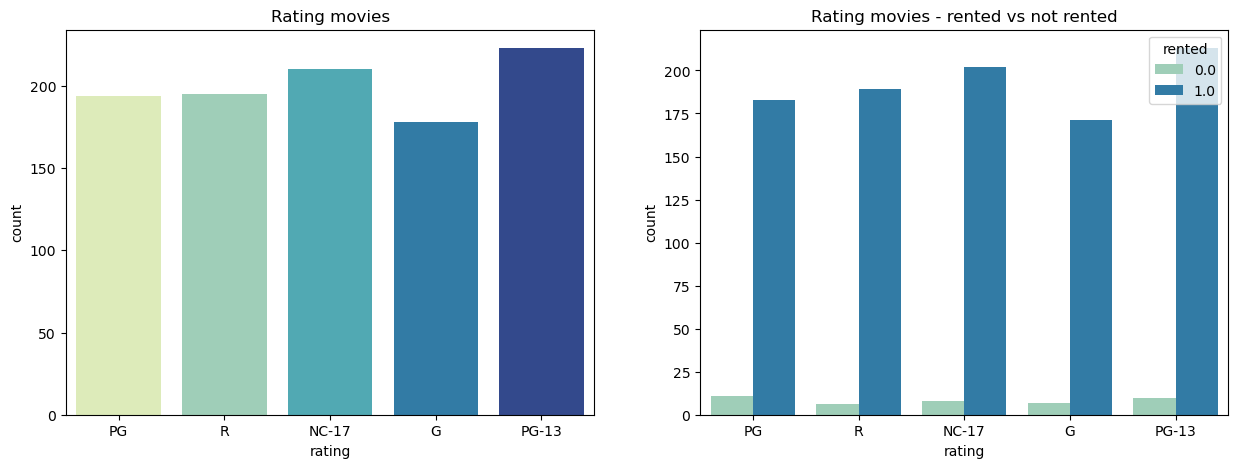

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x=df['rating'], palette='YlGnBu', ax=ax[0])
ax[0].set_title('Rating movies')
sns.countplot(x=df['rating'], hue=df['rented'], palette='YlGnBu', ax=ax[1])
ax[1].set_title('Rating movies - rented vs not rented')
plt.show()

#### Check Film Category

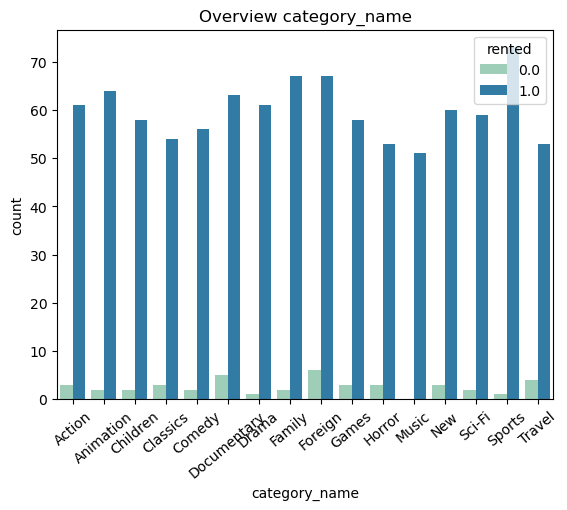

In [26]:
for cat in ['category_name']:
    sns.countplot(x=df[cat], hue=df['rented'], palette='YlGnBu')
    plt.xticks(rotation=40)
    plt.title(f'Overview {cat}')
    plt.show()

In [85]:
cr = pd.crosstab(df['category_name'], df['rented'])
cr['percent_not_rented_to_total'] = round(l[0.0] / (l[0.0] + l [1.0]), 2)
cr.sort_values('percent_not_rented_to_total', ascending=False)

rented,0.0,1.0,percent_not_rented_to_total
category_name,,,
Foreign,6,67,0.08
Documentary,5,63,0.07
Travel,4,53,0.07
Action,3,61,0.05
Classics,3,54,0.05
Games,3,58,0.05
Horror,3,53,0.05
New,3,60,0.05
Animation,2,64,0.03


- Obeservation: 'least' favourit category for films to rent is Foreign and Documentary 

# Feature Engineering

In [86]:
# helper function to convert special_features column to seveal columns with one special per column
def extract_special_features():
    # extract set of special features
    special_features = set()
    for specials in df['special_features'].unique():
        [special_features.add(c) for c in specials.split(",")]

    # create new columns in df for every special feature and set to 0
    for feature in special_features:
        df[feature] = 0

    # extract special features per film and fill up the respective column with 1
    for i, row in df.iterrows():
        for f in row['special_features'].split(','):
            df.at[i, f] = 1

    # drop special_features initial column
    df.drop('special_features', axis=1, inplace=True)
    # clean headers
    df.columns = [col.lower().replace(' ', '_')for col in df.columns]

In [28]:
extract_special_features()

In [87]:
df.head(1)

,title,description,rental_duration,rental_rate,length,replacement_cost,rating,special_features,category_name,times_rented_july_2005,times_rented_june_2005,times_rented_may_2005,rented,length_category
film_id,,,,,,,,,,,,,,
19,AMADEUS HOLY,A Emotional Display of a Pioneer And a Technic...,6,0.99,113,20.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",Action,8.0,4.0,1.0,1.0,medium


- drop title and description for now

In [88]:
df.drop(['title', 'description'], axis=1, inplace=True)

In [89]:
df.head(1)

,rental_duration,rental_rate,length,replacement_cost,rating,special_features,category_name,times_rented_july_2005,times_rented_june_2005,times_rented_may_2005,rented,length_category
film_id,,,,,,,,,,,,
19,6,0.99,113,20.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",Action,8.0,4.0,1.0,1.0,medium


# Train and evaluate

### Helper Functions and Train Test Split

In [91]:
data = df.copy()
y = data['rented']
X = data.drop('rented', axis=1, inplace=False)

In [92]:
def make_custom_pipeline(scaler, sampler, model, num_features, cat_features):
    return Pipeline([
            ('scaling', ColumnTransformer([
                ('numerical', scaler, num_features),
                ('categorical', OneHotEncoder(sparse=False), cat_features)
            ])),
            ('sampling', sampler),
            ('model', model)])

In [93]:
def display_confusion_matrix(y_pred, y, title, classes):
    cm = confusion_matrix(y, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(colorbar=False)
    disp.ax_.set_title(title)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Logistic Regression with SMOTE

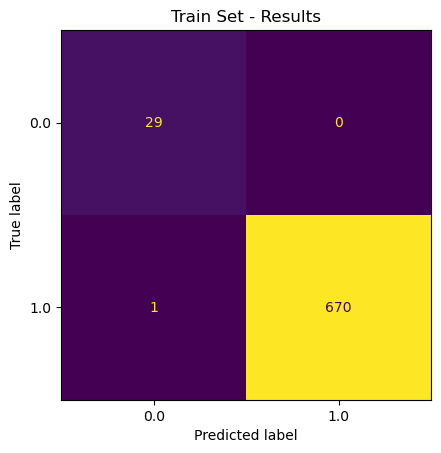

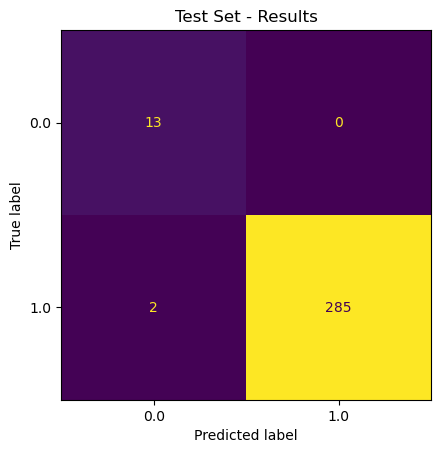

In [101]:
log_model = make_custom_pipeline(StandardScaler(), SMOTE(), LogisticRegression(), 
                                 X.select_dtypes('number').columns,
                                 X.select_dtypes('object').columns)

log_model.fit(X_train, y_train)

y_train_pred = log_model.predict(X_train)
y_test_pred = log_model.predict(X_test)

display_confusion_matrix(y_train_pred, y_train, 'Train Set - Results', log_model[2].classes_)
display_confusion_matrix(y_test_pred, y_test, 'Test Set - Results', log_model[2].classes_)

In [97]:
print('=== Train Set ===')
print(classification_report(y_train, y_train_pred))
print('=== Test Set ===')
print(classification_report(y_test, y_test_pred))

=== Train Set ===
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        29
         1.0       1.00      1.00      1.00       671

    accuracy                           1.00       700
   macro avg       0.98      1.00      0.99       700
weighted avg       1.00      1.00      1.00       700

=== Test Set ===
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93        13
         1.0       1.00      0.99      1.00       287

    accuracy                           0.99       300
   macro avg       0.93      1.00      0.96       300
weighted avg       0.99      0.99      0.99       300



### Observations:
- positive class: rented prediction is very good with precision and recall 1
- negative class: some are falsely predicted as rented - precision for negative class is 0.97 which is still very
good
- overall accuracy is 0.99

### Logistic Regression with RandomUnderSampler

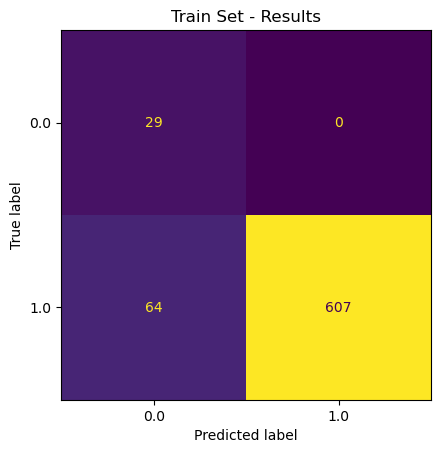

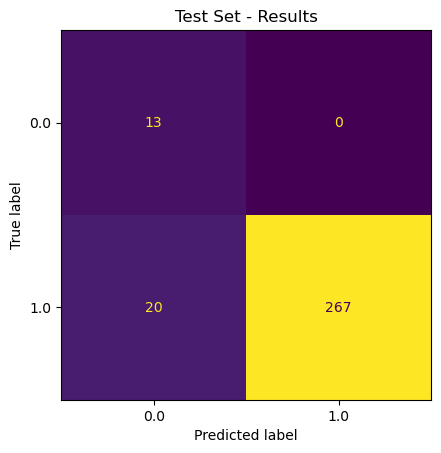

In [102]:
log_model_rus = make_custom_pipeline(StandardScaler(), RandomUnderSampler(), LogisticRegression(), 
                                     X.select_dtypes('number').columns,
                                     X.select_dtypes('object').columns)

log_model_rus.fit(X_train, y_train)

y_train_pred_rus = log_model_rus.predict(X_train)
y_test_pred_rus = log_model_rus.predict(X_test)

display_confusion_matrix(y_train_pred_rus, y_train, 'Train Set - Results', log_model_rus[2].classes_)
display_confusion_matrix(y_test_pred_rus, y_test, 'Test Set - Results', log_model_rus[2].classes_)

In [100]:
print('=== Train Set ===')
print(classification_report(y_train, y_train_pred_rus))
print('=== Test Set ===')
print(classification_report(y_test, y_test_pred_rus))

=== Train Set ===
              precision    recall  f1-score   support

         0.0       0.38      1.00      0.55        29
         1.0       1.00      0.93      0.96       671

    accuracy                           0.93       700
   macro avg       0.69      0.96      0.76       700
weighted avg       0.97      0.93      0.95       700

=== Test Set ===
              precision    recall  f1-score   support

         0.0       0.41      1.00      0.58        13
         1.0       1.00      0.93      0.97       287

    accuracy                           0.94       300
   macro avg       0.70      0.97      0.77       300
weighted avg       0.97      0.94      0.95       300



### Observations:
- overall accuracy decreased from 0.99 (with SMOTE) to 0.94 here with RUS
- precision for negative class decreased from 0.97 (with SMOTE) to 0.38 with RUS
- positive class: rented prediction is very good with precision 1; recall here is 0.93 however (compared to 1.0 with SMOTE)
- overall using SMOTE to combat target class imbalance seems to yield better model performance in this setup